# Transfer learning with tensorflow Part 3: Scaling UP

We have seen the power of transfer learning. How we extract features from the pretrained models and use it for our advanatges. We have trained and fine tune Efficient NetB0 on 1% 10% and 100% of 10 classes.

Now it is the time to scale up the model.
We are using 101 classes of food images from the imagenet dataset. And Make a big dog model. We will trained the 101 classes of images with 10% of images of each class(by leveraging the power of transfer learning).
Our baseline to beat the 50.76% accuracy across 101 classes.


In [1]:
#Check to see if we are using GPU or not.
!nvidia-smi

Mon Jul 29 11:20:58 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 1. Become one with the data

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2024-07-29 11:21:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.207, 74.125.20.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: '101_food_classes_10_percent.zip'

101_food_classes_10 100%[===================>]   1.51G   221MB/s    in 7.3s    

2024-07-29 11:21:12 (213 MB/s) - '101_food_classes_10_percent.zip' saved [1625420029/1625420029]



In [3]:
## Creating helper function
!wget https://raw.githubusercontent.com/varmatilak22/learning_tensorflow/main/extras/helper_func.py

#Import the helper function
from helper_func import unzip_data,create_tensorboard_callback,walk_through_dir,plot_loss_curves,compare_historys,create_data_aug

--2024-07-29 11:21:14--  https://raw.githubusercontent.com/varmatilak22/learning_tensorflow/main/extras/helper_func.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13288 (13K) [text/plain]
Saving to: 'helper_func.py'

helper_func.py      100%[===================>]  12.98K  --.-KB/s    in 0s      

2024-07-29 11:21:14 (32.9 MB/s) - 'helper_func.py' saved [13288/13288]



2024-07-29 11:21:17.356139: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 11:21:17.356289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 11:21:17.557021: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
unzip_data('101_food_classes_10_percent.zip')

In [42]:
#Global Variables
IMG_SIZE=(224,224)
BATCH_SIZE=32
EPOCHS=5

#Directory path
train_dir_all_data='101_food_classes_10_percent/train/'
test_dir_all_data='101_food_classes_10_percent/test/'

#image dataset directory
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_data_all_10_percent=image_dataset_from_directory(train_dir_all_data,
                                                       label_mode='categorical',
                                                       image_size=IMG_SIZE,
                                                      shuffle=False)
test_data_all_10_percent=image_dataset_from_directory(test_dir_all_data,
                                                      label_mode='categorical',
                                                      image_size=IMG_SIZE,
                                                     shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [6]:
#How many classes?
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ravioli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ceviche'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/escargots'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spring_rolls'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_fries'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/poutine'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macaroni_and_cheese'.
There are 0 directories and 250 images in '1

## Train the BIG_DOG_MODEL with transfer learning 10% of food 101 food classes.
Here are the steps we're goign to use:
* Create a ModelCheckpoint CallBack
* Create a Data Augmentation layer to build the augmentation layer right into the model.
* Build headless (No top layer ) functional EfficientNetB0 backboned model(we'll create our own output layer)
* Compile the model
* Feature Extraction for 5 full classes (5 Epochs on train dataset and validate on 15% of the data to save the epoch time.)

In [14]:
#Create a modelCheckpoint callback
checkpoint_path='101_classes_10_percent_data_model_checkpoints/checkpoint.weights.h5'

def model_checkpoint_callback(checkpoint_path):
  """
  Function to create a model checkpoint callback
  Here it will be used to load the weights of a trained model for fine tunning.
  """
  modelcheckpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                              save_weights_only=True,
                                                              save_best_only=True,
                                                              save_freq='epoch',
                                                              verbose=1)
  return modelcheckpoint_callback

In [8]:
#Import tensorflow
import tensorflow as tf

#Create a data augmentation layer
from tensorflow.keras.layers import RandomFlip,RandomRotation,RandomZoom,RandomWidth,RandomHeight,Rescaling

data_aug=tf.keras.models.Sequential([
    RandomFlip('horizontal'),
    RandomZoom(0.2),
    RandomRotation(0.2),
    RandomWidth(0.2),
    RandomHeight(0.2), #Efficient net models has inbuild rescaling
    #Rescaling(1/255) #Required in models like ResNet50
],name='Data_Augmentation_Layer')

In [9]:
# Setup the base_model and freeze the layers (this will extract features)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#Create the model

# 1. Create a Input layer
input_layer=tf.keras.layers.Input(shape=IMG_SIZE+(3,),
                                  name='Input_layer')
x=data_aug(input_layer)
x=base_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
output_layer=tf.keras.layers.Dense(101,activation='softmax')(x)

model=tf.keras.models.Model(input_layer,output_layer)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
#Get the summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Data_Augmentation_Layer         │ (None, None, None, 3)  │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [43]:
#Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

#Fit the model
history_all_classes_10_percent=model.fit(test_data_all_10_percent,
          epochs=EPOCHS,
          steps_per_epoch=len(test_data_all_10_percent),
          validation_data=train_data_all_10_percent,
          validation_steps=int(0.25*len(train_data_all_10_percent)),
          callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                 experiment_name='all_classes_10_percent_feature_extraction'),model_checkpoint_callback(checkpoint_path)])

Saving TensorBoard log files to: transfer_learning/all_classes_10_percent_feature_extraction/20240729-121409
Epoch 1/5


2024-07-29 12:14:21.010610: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


789/790 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.0384 - loss: 4.6319
Epoch 1: val_loss improved from inf to 7.70929, saving model to 101_classes_10_percent_data_model_checkpoints/checkpoint.weights.h5
790/790 ━━━━━━━━━━━━━━━━━━━━ 87s 95ms/step - accuracy: 0.0383 - loss: 4.6318 - val_accuracy: 0.0000e+00 - val_loss: 7.7093
Epoch 2/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 7.70929
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 7.9215
Epoch 3/5
789/790 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.0238 - loss: 3.7045
Epoch 3: val_loss improved from 7.70929 to 7.12681, saving model to 101_classes_10_percent_data_model_checkpoints/checkpoint.weights.h5
790/790 ━━━━━━━━━━━━━━━━━━━━ 69s 88ms/step - accuracy: 0.0238 - loss: 3.7043 - val_accuracy: 0.0021 - val_loss: 7.1268
Epoch 4/5

Epoch 4: val_loss did not improve from 7.12681
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0387 - val_loss: 7.4631
Epoch 5/5
789/790 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.0572 - loss: 3.2689
Epoch 5: val_loss improved from 7.12681 to 1.40729, saving model to 101_classes_10_percent_data_model_checkpoints/checkpoint.weights.h5
790/790 ━━━━━━━━━━━━━━━━━━━━ 66s 83ms/step - accuracy: 0.0573 - loss: 3.2683 

In [45]:
# Evaluate the model
fine_tunning_result=model.evaluate(train_data_all_10_percent)

237/237 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 5.8155e-04 - loss: 9.6719


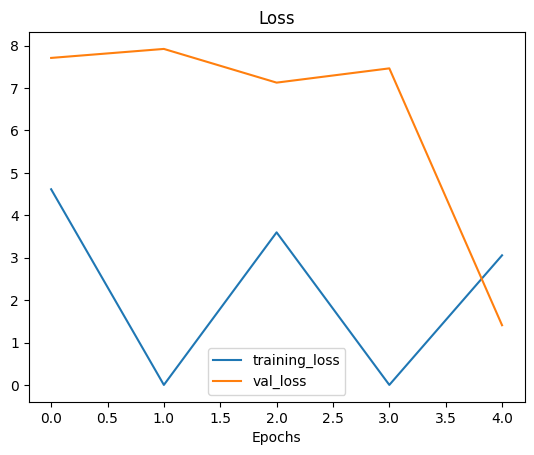

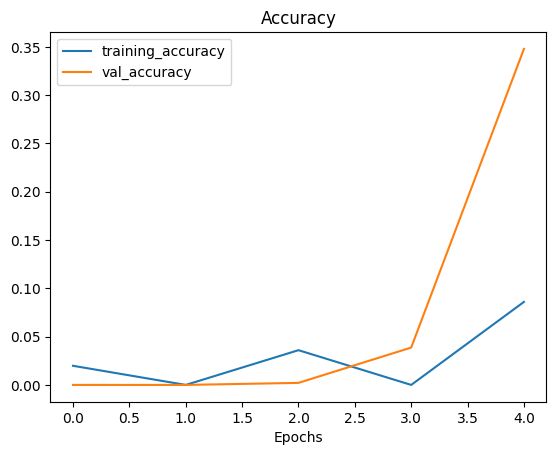

In [46]:
plot_loss_curves(history_all_classes_10_percent)

### Fine Tunning

In [47]:
#Unfreeze the layers
base_model.trainable=True

#Refreeze the layers except last 5
for i in base_model.layers[:-5]:
  i.trainable=False

#Checking for the layer which are freeze
for layer_number,layer in enumerate(base_model.layers):
  if layer.trainable==True:
    print(f"Layer{layer_number} {layer.name},{layer.trainable}")

Layer233 block7a_project_conv,True
Layer234 block7a_project_bn,True
Layer235 top_conv,True
Layer236 top_bn,True
Layer237 top_activation,True


In [20]:
#Recompile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [48]:
#Fine-tune for more 5 Epochs
initial_epochs=5
fine_tune_epochs=10+initial_epochs

#Fine-tune the model
history_all_classes_10_percent_fine_tune=model.fit(test_data_all_10_percent,
                                                   epochs=fine_tune_epochs,
                                                   initial_epoch=initial_epochs,
                                                   steps_per_epoch=len(test_data_all_10_percent),
                                                   validation_data=train_data_all_10_percent,
                                                   validation_steps=int(0.25*len(test_data_all_10_percent)),
                                                   callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                          experiment_name='all_classes_10_percent_fine_tune_last_5')])

Saving TensorBoard log files to: transfer_learning/all_classes_10_percent_fine_tune_last_5/20240729-121923
Epoch 6/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 72s 91ms/step - accuracy: 0.1303 - loss: 2.7920 - val_accuracy: 4.7589e-04 - val_loss: 10.3777
Epoch 7/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0669 - val_loss: 9.0790
Epoch 8/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 70s 88ms/step - accuracy: 0.2077 - loss: 2.3965 - val_accuracy: 0.0000e+00 - val_loss: 10.1244
Epoch 9/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0905 - val_loss: 8.8567
Epoch 10/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 69s 88ms/step - accuracy: 0.2997 - loss: 2.0572 - val_accuracy: 1.5863e-04 - val_loss: 12.4750
Epoch 11/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0999 - val_loss: 10.8885
Epoch 12/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 67s 84ms/step - accuracy: 0.3974 - l

In [50]:
#Evaluate the whole test dataset
fine_tune_all_classes_results=model.evaluate(train_data_all_10_percent)

237/237 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 4.4638e-04 - loss: 9.9449


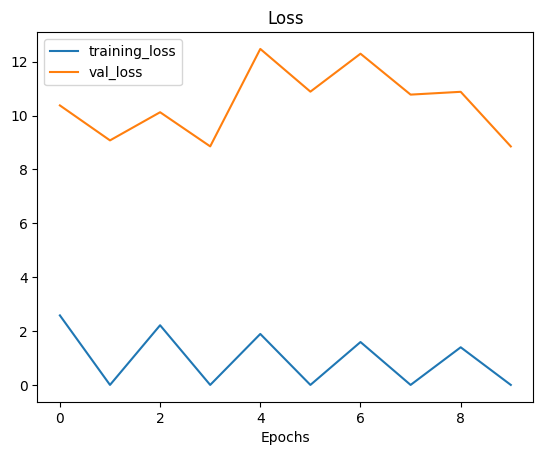

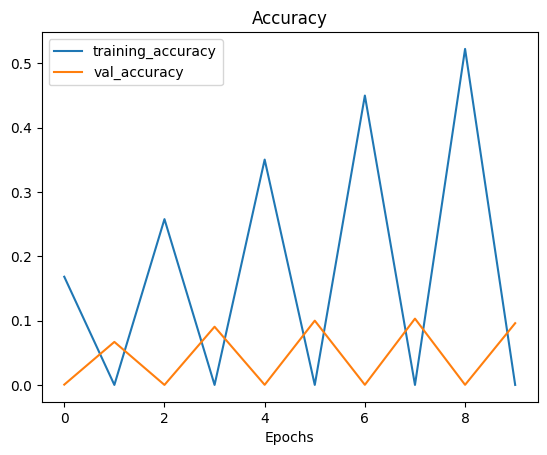

In [51]:
plot_loss_curves(history_all_classes_10_percent_fine_tune)

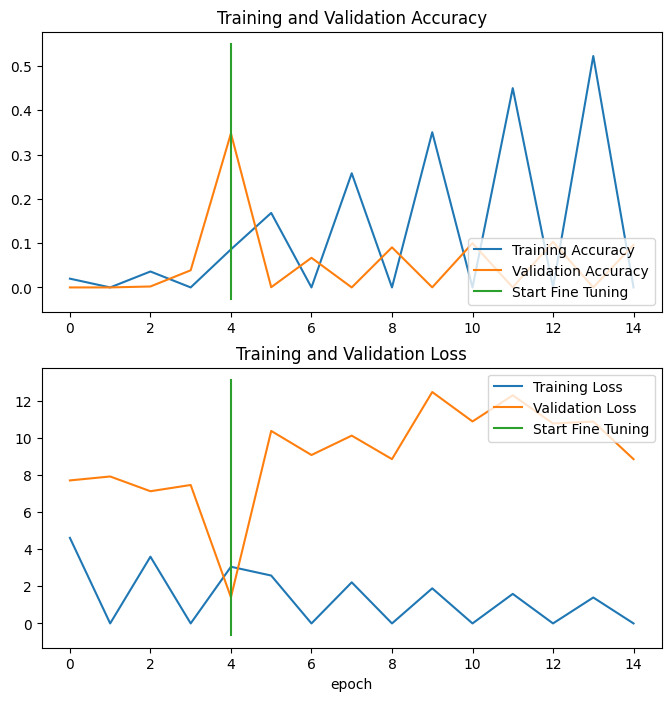

In [52]:
#Compare Historys
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [28]:
### Save and load our model

#Save model
#model.save('drive/MyDrive/tensorflow_cousre/101_classes_10_percent_data_model')
model.save('101_classes_10_percent_data.keras')
#Load the model
loaded_model=tf.keras.models.load_model('101_classes_10_percent_data.keras')

In [29]:
#Evaluate the model and compare the predictions to pre-saved model
loaded_model_results=loaded_model.evaluate(test_data_all_10_percent)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5212 - loss: 1.8381


[1.7178581953048706, 0.5477227568626404]

In [31]:
fine_tune_all_classes_results

[1.6538563966751099, 0.5632475018501282]

## Fine Tunning part:2 Unfreeze 10 layers of base model

In [76]:
#Unfreeze the layers
base_model.trainable=True

for i in base_model.layers[:-10]:
    i.trainable=False
    print(i.name,i.trainable)
    
for i,layer in enumerate(base_model.layers):
    print(i,layer.name,layer.trainable)

input_layer False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [77]:
#COmpile the model
model.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
             metrics=['accuracy'])

In [81]:
fine_tune_epoch=initial_epochs+5

history_all_data_10_layers=model.fit(test_data_all_10_percent,
                                    epochs=fine_tune_epochs,
                                    initial_epoch=initial_epochs,
                                    steps_per_epoch=len(test_data_all_10_percent),
                                    validation_data=train_data_all_10_percent,
                                    validation_steps=int(0.25*len(train_data_all_10_percent)),
                                    callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                          experiment_name='all_data_10_percent_unfreeze_10_layers')])



Saving TensorBoard log files to: transfer_learning/all_data_10_percent_unfreeze_10_layers/20240729-124431
Epoch 6/15


2024-07-29 12:45:38.854007: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


790/790 ━━━━━━━━━━━━━━━━━━━━ 127s 75ms/step - accuracy: 0.0745 - loss: 5.4801 - val_accuracy: 0.0064 - val_loss: 6.9699
Epoch 7/15


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 5.2966e-04 - val_loss: 7.2409
Epoch 8/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.1313 - loss: 4.0366 - val_accuracy: 0.0132 - val_loss: 5.8017
Epoch 9/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0726 - val_loss: 6.3502
Epoch 10/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 51s 64ms/step - accuracy: 0.1806 - loss: 3.3615 - val_accuracy: 0.1739 - val_loss: 3.7529
Epoch 11/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0360 - val_loss: 5.1624
Epoch 12/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 54s 68ms/step - accuracy: 0.2123 - loss: 3.0860 - val_accuracy: 0.0323 - val_loss: 5.1458
Epoch 13/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0493 - val_loss: 4.8429
Epoch 14/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - accuracy: 0.

In [82]:
model.evaluate(train_data_all_10_percent)

237/237 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.0552 - loss: 4.6169


[4.802837371826172, 0.05544554442167282]

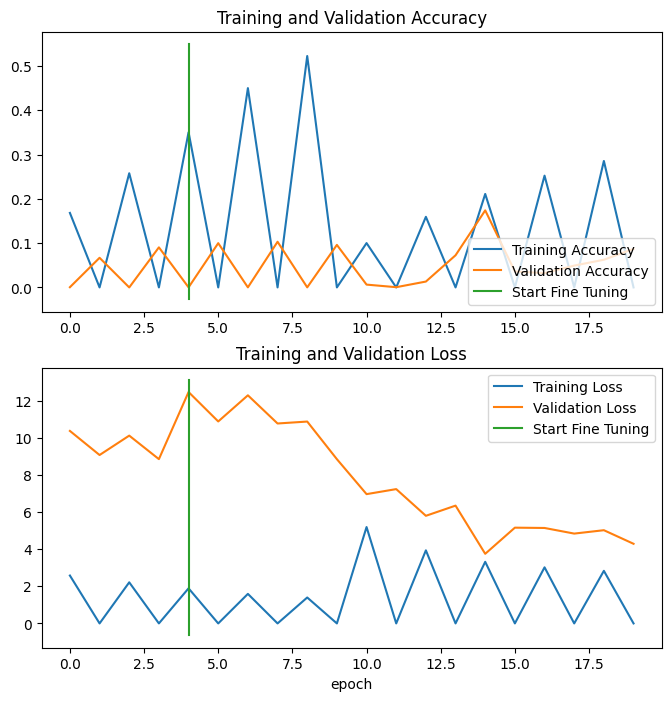

In [84]:
compare_historys(original_history=history_all_classes_10_percent_fine_tune,
                new_history=history_all_data_10_layers,
                initial_epochs=5)

In [93]:
history_10=model.fit(test_data_all_10_percent,
         epochs=10,
         steps_per_epoch=len(test_data_all_10_percent),
         validation_data=train_data_all_10_percent,
         validation_steps=int(0.15*len(train_data_all_10_percent)))

Epoch 1/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 49s 62ms/step - accuracy: 0.2926 - loss: 2.6774 - val_accuracy: 0.0688 - val_loss: 4.0896
Epoch 2/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


790/790 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0696 - val_loss: 4.4646
Epoch 3/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/step - accuracy: 0.3039 - loss: 2.6490 - val_accuracy: 0.0929 - val_loss: 4.2981
Epoch 4/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0616 - val_loss: 4.7287
Epoch 5/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 80s 61ms/step - accuracy: 0.3192 - loss: 2.5876 - val_accuracy: 0.1286 - val_loss: 4.0582
Epoch 6/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0482 - val_loss: 4.7093
Epoch 7/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/step - accuracy: 0.3344 - loss: 2.5262 - val_accuracy: 0.1029 - val_loss: 3.9213
Epoch 8/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0688 - val_loss: 4.0209
Epoch 9/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - accuracy: 0.3334 - lo

In [94]:
epochs_result_10_layer=model.evaluate(train_data_all_10_percent)

237/237 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.0785 - loss: 4.1759


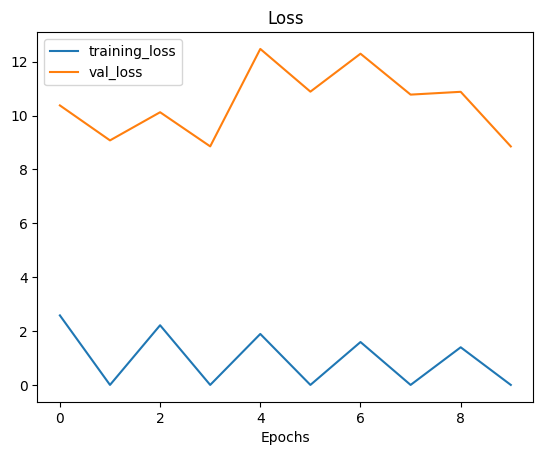

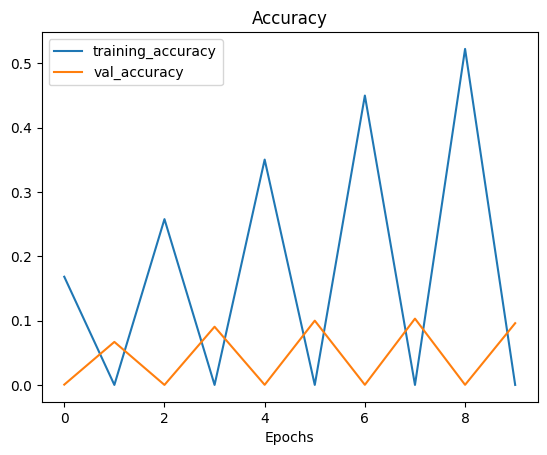

In [95]:
plot_loss_curves(history_all_classes_10_percent_fine_tune)

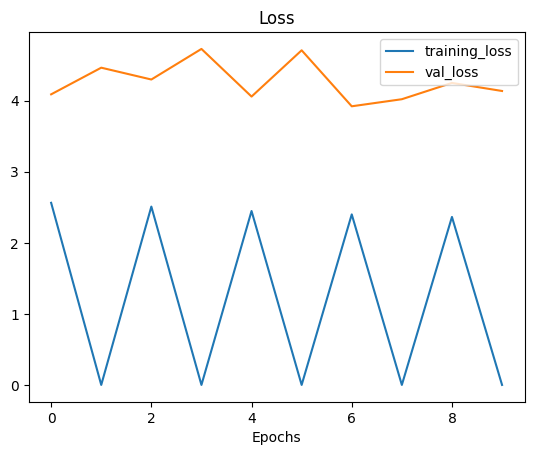

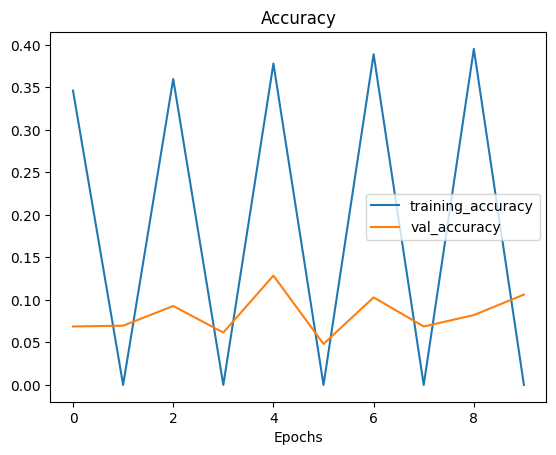

In [96]:
plot_loss_curves(history_10)

In [97]:
fine_tune_all_classes_results,epochs_result_10_layer

([10.542413711547852, 0.016237623989582062],
 [4.218985080718994, 0.08686468750238419])

In [98]:
model.save('101_food_classes_10_percent.keras')